# Imports

In [ ]:
import requests
from typing import Dict, List

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

import sys, os
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

from hosvd_denoiser import (
    hosvd_denoise,
    compute_image_metrics,
    plot_comparison
)

# Data Preparation

### Simple Methods

In [ ]:
def read_image_from_url(url, flags=cv2.IMREAD_COLOR):
    response = requests.get(url)
    response.raise_for_status()
    img_array = np.array(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(img_array, flags)
    return img

def read_image_from_url_grayscale(url):
    img = read_image_from_url(url)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Data Input

### The testing images and metrics

In [ ]:
# List of subfolders, different sigma values, and metrics
folders = [
    "original_png",
    "noisy5",
    "noisy10",
    # "noisy15",
    "noisy25",
    "noisy35",
    "noisy50"
]
sigmas = [5, 10, 25, 35, 50]
metrics = ['MSE', 'RMSE', 'MAE', 'PSNR', 'SSIM', 'NRMSE', 'UQI']

In [ ]:
images: Dict[str, List[np.ndarray]] = {}

base_url = "https://github.com/clausmichele/CBSD68-dataset/blob/master/CBSD68"
for folder in folders:
    images[folder] = []
    for idx in range(68):
        filename = f"{idx:04d}.png"
        url = f"{base_url}/{folder}/{filename}?raw=true"
        img_arr = read_image_from_url_grayscale(url)
        images[folder].append(img_arr)

original_images = images['original_png']

### Folders, Sigmas, and Metrics

In [ ]:
# List of subfolders, different sigma values, and metrics
folders = [
    "original_png",
    "noisy5",
    "noisy10",
    "noisy25",
    "noisy35",
    "noisy50"
]
sigmas = [5, 10, 25, 35, 50]
metrics = ['MSE', 'RMSE', 'MAE', 'PSNR', 'SSIM', 'NRMSE', 'UQI']

### Initialization of Results Dataframe

In [ ]:
df_columns = [
    'Image Id',
    'Sigma Value',
    'Noisy-Original MSE',
    'Denoised-Original MSE',
    'Noisy-Original RMSE',
    'Denoised-Original RMSE',
    'Noisy-Original MAE',
    'Denoised-Original MAE',
    'Noisy-Original PSNR',
    'Denoised-Original PSNR',
    'Noisy-Original SSIM',
    'Denoised-Original SSIM',
    'Noisy-Original NRMSE',
    'Denoised-Original NRMSE',
    'Noisy-Original UQI',
    'Denoised-Original UQI'
]

df_results = pd.DataFrame(columns=df_columns)

# Image-Specific Results

In [ ]:
plot_comparison(0)

In [ ]:
plot_comparison(5)

In [ ]:
plot_comparison(12)

# Full Dataset Evaluation

In [ ]:
for folder, sigma in zip(folders[1:], sigmas):
    noisy_list = images[folder]

    for idx, noisy_img in enumerate(noisy_list):
        if idx == 0:
            print(f"Starting the folder \"{folder}\"")
        orig_img = original_images[idx]

        denoised_img = hosvd_denoise(
            noisy_img,
            sigma=sigma,
            patch_size=8,
            search_radius=20,
            max_patches=30,
            stride=4
        )

        data_range = orig_img.max() - orig_img.min()
        metrics = compute_image_metrics(
            original=orig_img,
            noisy=noisy_img,
            denoised=denoised_img,
            data_range=data_range
        )

        row = {
            'Image Id': f"{idx:02d}",
            'Sigma Value': sigma,
            'Noisy-Original MSE': metrics['noisy_vs_original'].get('MSE'),
            'Denoised-Original MSE': metrics['denoised_vs_original'].get('MSE'),
            'Noisy-Original RMSE': metrics['noisy_vs_original'].get('RMSE'),
            'Denoised-Original RMSE': metrics['denoised_vs_original'].get('RMSE'),
            'Noisy-Original MAE': metrics['noisy_vs_original'].get('MAE'),
            'Denoised-Original MAE': metrics['denoised_vs_original'].get('MAE'),
            'Noisy-Original PSNR': metrics['noisy_vs_original'].get('PSNR'),
            'Denoised-Original PSNR': metrics['denoised_vs_original'].get('PSNR'),
            'Noisy-Original SSIM': metrics['noisy_vs_original'].get('SSIM'),
            'Denoised-Original SSIM': metrics['denoised_vs_original'].get('SSIM'),
            'Noisy-Original NRMSE': metrics['noisy_vs_original'].get('NRMSE'),
            'Denoised-Original NRMSE': metrics['denoised_vs_original'].get('NRMSE'),
            'Noisy-Original UQI': metrics['noisy_vs_original'].get('UQI'),
            'Denoised-Original UQI': metrics['denoised_vs_original'].get('UQI')
        }

        df_results.loc[len(df_results)] = row

# Full Results

In [ ]:
df_results

,Image Id,Sigma Value,Noisy-Original MSE,Denoised-Original MSE,Noisy-Original RMSE,Denoised-Original RMSE,Noisy-Original MAE,Denoised-Original MAE,Noisy-Original PSNR,Denoised-Original PSNR,Noisy-Original SSIM,Denoised-Original SSIM,Noisy-Original NRMSE,Denoised-Original NRMSE,Noisy-Original UQI,Denoised-Original UQI
0,00,5,11.630929,2.068524,3.410415,1.438236,97.855577,1.064772,34.254109,41.753649,0.768819,0.970222,0.028835,0.012160,0.991475,0.998641
1,01,5,11.504381,12.738877,3.391811,3.569156,97.949521,2.763448,36.701127,36.258448,0.961013,0.957997,0.035859,0.037734,0.995115,0.994480
2,02,5,11.390179,6.695445,3.374934,2.587556,99.748259,1.744998,37.428169,39.735680,0.899382,0.965556,0.047326,0.036285,0.997882,0.998760
3,03,5,11.425969,13.182911,3.380232,3.630828,95.700358,2.757809,36.989028,36.367845,0.954947,0.958447,0.031347,0.033671,0.998382,0.998116
4,04,5,11.546104,13.891798,3.397956,3.727170,97.954340,2.741630,36.833885,36.030655,0.944859,0.962561,0.040300,0.044205,0.997390,0.996815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,63,50,811.053892,194.296915,28.479008,13.939043,145.876231,12.134077,18.937514,25.143352,0.262035,0.718118,0.505001,0.247173,0.898764,0.973585
336,64,50,978.335626,297.154678,31.278357,17.238175,128.759600,12.996476,18.157532,23.332585,0.476715,0.675533,0.327683,0.180593,0.822060,0.930497
337,65,50,985.347783,232.376916,31.390250,15.243914,125.770669,11.627309,18.057579,24.331545,0.392968,0.592058,0.291533,0.141576,0.832391,0.950573
338,66,50,884.863699,242.932907,29.746659,15.586305,138.324298,13.001747,18.662040,24.275940,0.307712,0.620493,0.405092,0.212255,0.892307,0.967928


In [ ]:
df_results.to_csv('final_results.csv', index=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Data Analysis

In [ ]:
df_metrics = df_results.drop(columns=['Image Id'])

df_mean_by_sigma = df_metrics.groupby('Sigma Value').mean().reset_index()

df_mean_by_sigma = df_mean_by_sigma.round(4)

In [ ]:
df_mean_by_sigma

,Sigma Value,Noisy-Original MSE,Denoised-Original MSE,Noisy-Original RMSE,Denoised-Original RMSE,Noisy-Original MAE,Denoised-Original MAE,Noisy-Original PSNR,Denoised-Original PSNR,Noisy-Original SSIM,Denoised-Original SSIM,Noisy-Original NRMSE,Denoised-Original NRMSE,Noisy-Original UQI,Denoised-Original UQI
0,5,11.4140,11.4257,3.3783,3.3247,96.0713,2.4799,36.8297,37.1308,0.9377,0.9636,0.0325,0.0318,0.9971,0.9969
1,10,43.8915,32.6349,6.6237,5.5422,110.7709,4.0235,30.9829,32.8203,0.8212,0.9185,0.0636,0.0528,0.9887,0.9912
2,25,262.7016,98.9967,16.2003,9.5808,120.4385,6.9888,23.2171,28.1108,0.5456,0.8076,0.1555,0.0913,0.9370,0.9751
3,35,498.9081,143.6423,22.3246,11.5667,122.6048,8.5636,20.4322,26.4492,0.4343,0.7464,0.2141,0.1105,0.8883,0.9647
4,50,956.3494,217.5179,30.9087,14.2930,124.4505,10.8415,17.6062,24.5759,0.3254,0.6676,0.2963,0.1368,0.8073,0.9471


In [ ]:
df_mean_by_sigma.to_csv('final_results.csv', index=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
overall_means = df_metrics.mean(numeric_only=True)
print(overall_means)

Sigma Value                 25.000000
Noisy-Original MSE         354.652941
Denoised-Original MSE      100.843488
Noisy-Original RMSE         15.887115
Denoised-Original RMSE       8.861496
Noisy-Original MAE         114.867213
Denoised-Original MAE        6.579459
Noisy-Original PSNR         25.813604
Denoised-Original PSNR      29.817406
Noisy-Original SSIM          0.612859
Denoised-Original SSIM       0.820736
Noisy-Original NRMSE         0.152398
Denoised-Original NRMSE      0.084642
Noisy-Original UQI           0.923705
Denoised-Original UQI        0.975001
dtype: float64


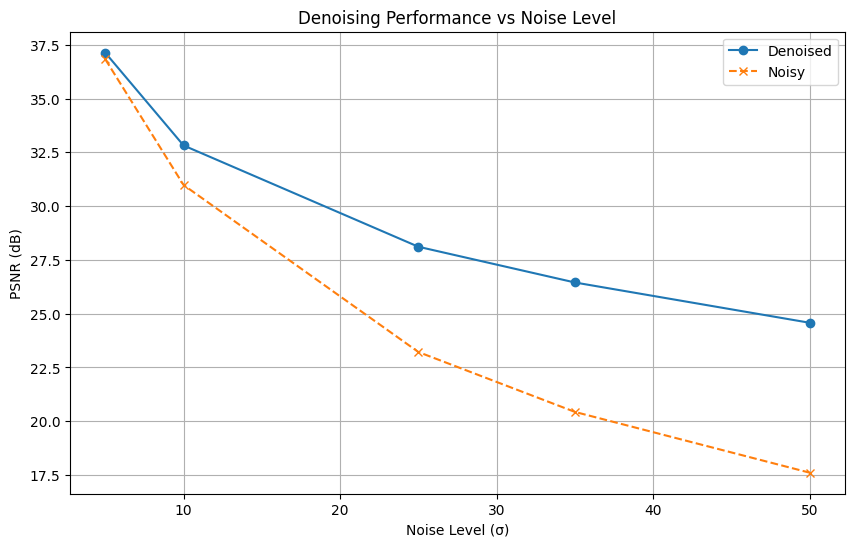

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_mean_by_sigma['Sigma Value'],
         df_mean_by_sigma['Denoised-Original PSNR'],
         'o-', label='Denoised')
plt.plot(df_mean_by_sigma['Sigma Value'],
         df_mean_by_sigma['Noisy-Original PSNR'],
         'x--', label='Noisy')
plt.xlabel('Noise Level (σ)')
plt.ylabel('PSNR (dB)')
plt.title('Denoising Performance vs Noise Level')
plt.legend()
plt.grid(True)
plt.show()